#### Multi-Class Prediction of Obesity Risk
[kaggle](https://www.kaggle.com/competitions/playground-series-s4e2)
##### 読み込み

In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

random_state = 14

##### データの読み込み

In [2]:
train_df = pd.read_csv(r'../data/input/train.csv')
test_df = pd.read_csv(r'../data/input/test.csv')

In [3]:
test_df['NObeyesdad'] = np.nan
df = pd.concat([train_df, test_df], ignore_index=True, sort=False)
print(train_df.shape)
print(test_df.shape)
print(df.shape)

(20758, 18)
(13840, 18)
(34598, 18)


In [4]:
# Id列削除前の型を確認
print("The train_df data size : {} ".format(train_df.shape))
print("The test_df data size : {} ".format(test_df.shape))

# Idだけ別に保持する
train_df_ID = train_df['id']
test_df_ID = test_df['id']

# 予測に不要なのでId列を削除する
train_df.drop("id", axis = 1, inplace = True)
test_df.drop("id", axis = 1, inplace = True)

# Id列削除後の型を確認
print("\nThe train_df data size : {} ".format(train_df.shape)) 
print("The test_df data size : {} ".format(test_df.shape))

The train_df data size : (20758, 18) 
The test_df data size : (13840, 18) 

The train_df data size : (20758, 17) 
The test_df data size : (13840, 17) 


In [5]:
# 数値データの統計量を確認
train_df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [6]:
# カテゴリデータの統計量を確認
train_df.describe(include=['O'])

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,20758,20758,20758,20758,20758,20758,20758,20758,20758
unique,2,2,2,4,2,2,3,5,7
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
freq,10422,17014,18982,17529,20513,20071,15066,16687,4046


##### データの加工
連結データの作成

In [7]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
#y_train = train_df.NObeyesdad.values
y_train = train_df[['NObeyesdad']]

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['NObeyesdad'], axis=1, inplace=True)

In [8]:
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34598 entries, 0 to 34597
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          34598 non-null  object 
 1   Age                             34598 non-null  float64
 2   Height                          34598 non-null  float64
 3   Weight                          34598 non-null  float64
 4   family_history_with_overweight  34598 non-null  object 
 5   FAVC                            34598 non-null  object 
 6   FCVC                            34598 non-null  float64
 7   NCP                             34598 non-null  float64
 8   CAEC                            34598 non-null  object 
 9   SMOKE                           34598 non-null  object 
 10  CH2O                            34598 non-null  float64
 11  SCC                             34598 non-null  object 
 12  FAF                             

In [9]:
# Label Encording
def all_label_encoding(df):
    for i in range(df.shape[1]):
        if df.dtypes.iloc[i] == 'object':
            # Label Encording
            le = LabelEncoder()
            df[df.columns[i]] = le.fit_transform(df[df.columns[i]])

all_label_encoding(all_data)


c:\Users\kppis\anaconda3\envs\kaggle-pra\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


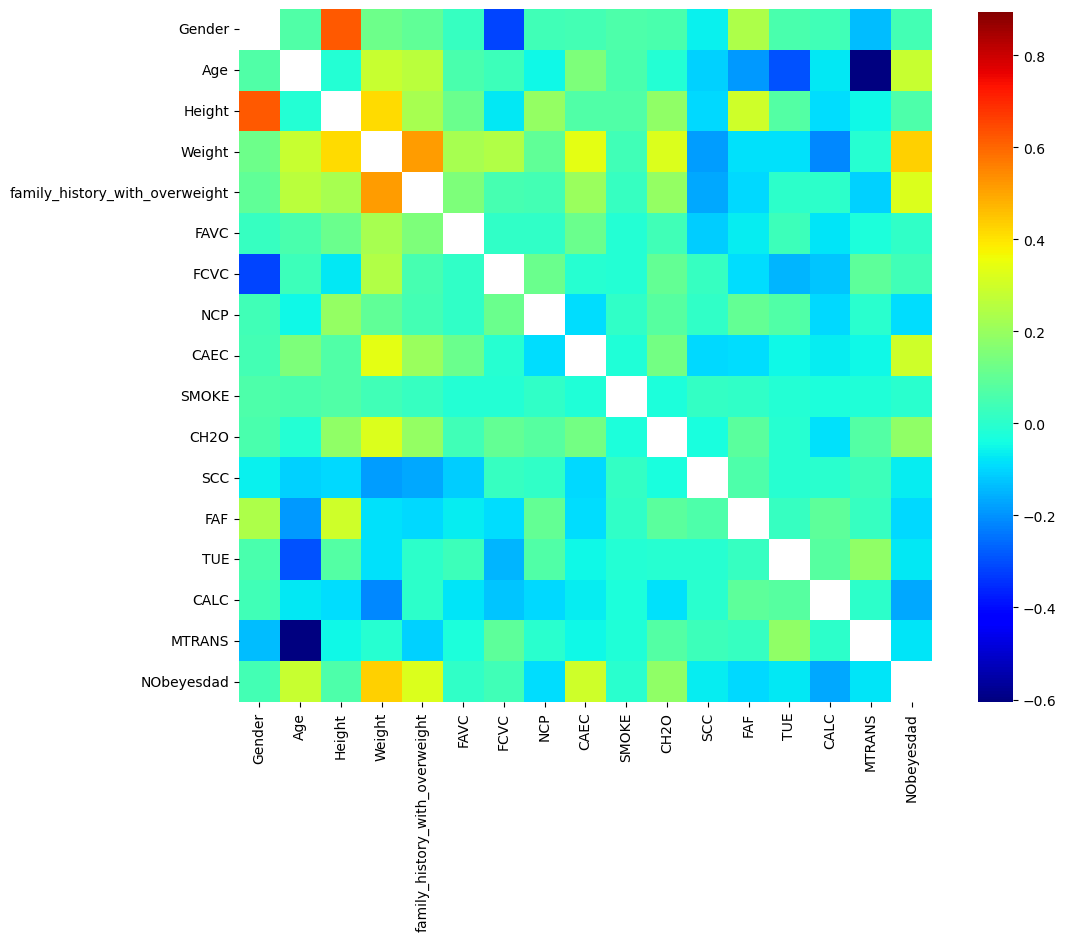

In [10]:
from matplotlib.colors import ListedColormap
def plot_corr(all_data, y_train, y_encod_f):
    if y_encod_f:
        # Label Encording
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_train = pd.DataFrame(y_train, columns=['NObeyesdad'])
    x_train = all_data[:y_train.shape[0]]
    df = pd.concat([x_train, y_train], axis=1)
    # 数値データのみを含む列を選択
    numeric_columns = df.select_dtypes(include=[np.number])
    # 相関行列を計算
    corrmat = numeric_columns.corr()
    plt.subplots(figsize=(12,9))
    # jetに1.0を白にしたカラーマップ
    myjet = ListedColormap([(1, 1, 1, 1) if i == 255 else plt.cm.jet(i) for i in range(256)])
    sns.heatmap(corrmat, vmax=0.9, square=True, cmap=myjet)

# 表示例
plot_corr(all_data, y_train, True)

##### モデルの学習

In [11]:
# データを分割する　ntrainを利用する
x_train = all_data[:ntrain]
x_test = all_data[ntrain:]
le = LabelEncoder()
y_train = le.fit_transform(y_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=random_state)

c:\Users\kppis\anaconda3\envs\kaggle-pra\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=2000, random_state=random_state)
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=14, ...)

##### 評価

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
pred_val = xgb_model.predict(x_val)
print(np.sqrt(mean_squared_error(y_val, pred_val)))

0.9140300524307181
